In [1]:
import re
import json
import numpy as np
import pandas as ps
import matplotlib
matplotlib.use('svg')
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [2]:
def throw_unused_chars_on_the_ground(string: str) -> str:
    """
    Remove undesirable characters.
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

data_file = '../data/all_sections_filtered.json'
with open(data_file, 'r') as in_file:
    dataset = ps.DataFrame(json.load(in_file))

print('Data shapes:', dataset.shape)
dataset.text = dataset.text.apply(throw_unused_chars_on_the_ground)
dataset.head(10)

Data shapes: (3056, 4)


,document_id,section_full_title,section_title,text
0,103uLzqu45vthv8iYk5jJu.,SECTION 1.Appointment of Warrant Agent.,Appointment of Warrant Agent.,the company hereby appoints the warrant agent ...
1,103uLzqu45vthv8iYk5jJu.,SECTION 2.Warrant Certificates.,Warrant Certificates.,the certificates including the global warrants...
2,103uLzqu45vthv8iYk5jJu.,SECTION 3.Execution of Warrant Certificates.,Execution of Warrant Certificates.,warrant certificates shall be signed on behalf...
3,103uLzqu45vthv8iYk5jJu.,SECTION 4.Registration and Countersignature.,Registration and Countersignature.,warrant certificates shall be countersigned by...
4,103uLzqu45vthv8iYk5jJu.,SECTION 5.Transfers and Exchanges.,Transfers and Exchanges.,the company will provide the warrant agent wit...
5,103uLzqu45vthv8iYk5jJu.,SECTION 6.Terms of Warrants,Terms of Warrants,(a)exercise price and exercise period the init...
6,103uLzqu45vthv8iYk5jJu.,SECTION 7.Payment of Taxes.,Payment of Taxes.,the company will pay all documentary stamp tax...
7,103uLzqu45vthv8iYk5jJu.,SECTION 8.Mutilated or Missing Warrant Certifi...,Mutilated or Missing Warrant Certificates.,in case any of the warrant certificates shall ...
8,103uLzqu45vthv8iYk5jJu.,SECTION 9.Reservation of Warrant Shares.,Reservation of Warrant Shares.,the company will at all times reserve and keep...
9,103uLzqu45vthv8iYk5jJu.,SECTION 10.Obtaining Stock Exchange Listings.,Obtaining Stock Exchange Listings.,the company will from time to time take all co...


In [3]:
print('document_id unique:', len(dataset.document_id.unique()))
print('section_title unique:', len(dataset.section_title.unique()))
print('section_full_title unique:', len(dataset.section_full_title.unique()))
print('text unique:', len(dataset.text.unique()))

document_id unique: 380
section_title unique: 2045
section_full_title unique: 2591
text unique: 2703


# Text clustering

For successfull clusterisation need to convert each text in dataset to vector of frequencies of words. 
Firstly need to make vector with count of words in current text and then transform it using term [TFIDF](https://en.wikipedia.org/wiki/Tf–idf).

In [4]:
import string
import collections

from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenise_text(text: str, stem=True):
    text = text.translate(str.maketrans('','',string.punctuation))
    tokens = word_tokenize(text)
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
    return tokens

def clusterize_texts(texts, clusters=10, n_jobs=-1):
    vectorizer = TfidfVectorizer(tokenizer=tokenise_text,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
    
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters, n_jobs=n_jobs)
    km_model.fit(tfidf_model)
    return km_model.labels_

In [5]:
from ipywidgets import interact, IntProgress

CLUSTER_RANGES = (25, 45)
progress = IntProgress(value=CLUSTER_RANGES[0],
                       min=CLUSTER_RANGES[0], max=CLUSTER_RANGES[1], step=1,
                       description='Loading:',
                       bar_style='success', # 'success', 'info', 'warning', 'danger' or ''
                       orientation='horizontal')

display(progress)
for cluster_count in range(CLUSTER_RANGES[0], CLUSTER_RANGES[1] + 1):
    clusters = clusterize_texts(dataset.text.values, clusters=cluster_count)
    dataset['cluster_by_text_' + str(cluster_count)] = clusters  # add results to dataset
    progress.value = cluster_count

A Jupyter Widget

Text(0,0.5,'Sections in cluster')

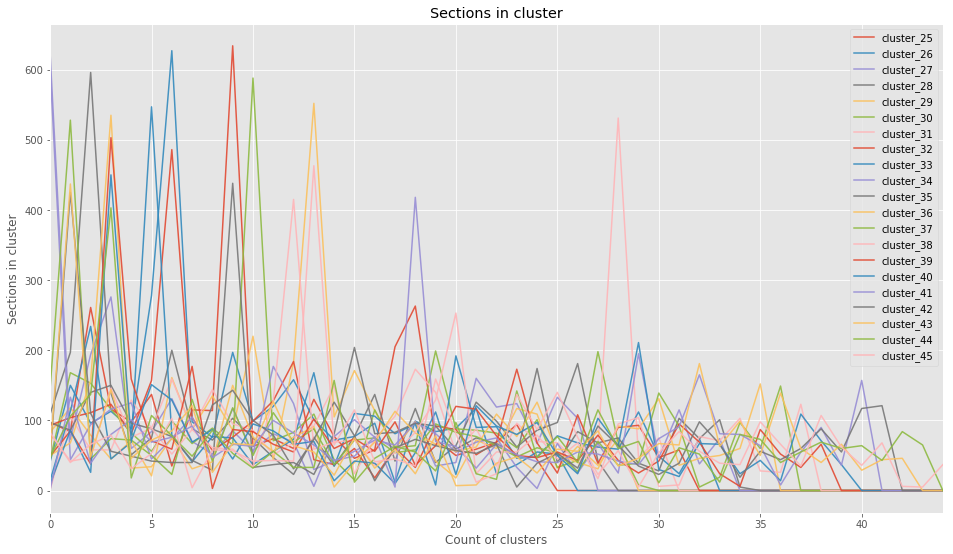

In [6]:
res_frame = ps.DataFrame()

for cluster in range(CLUSTER_RANGES[0], CLUSTER_RANGES[1] + 1):
    ucount = dataset['cluster_by_text_' + str(cluster)].value_counts()
    cluster_count = np.zeros(CLUSTER_RANGES[1])
    for c, cnt in ucount.items():
        cluster_count[c] = cnt
    res_frame['cluster_' + str(cluster)] = cluster_count

ax = res_frame.plot(kind="line", alpha=0.9, 
                    figsize=(16, 9), title='Sections in cluster')
ax.set_xlabel('Count of clusters')
ax.set_ylabel('Sections in cluster')

Let suppose that we have 35 unique clusters. 

So we will take `cluster_by_text_35` column as labels.

For future let's save data to __.csv__.

In [7]:
dataset.to_csv('../data/dataset.csv', sep='|')
# tmp = ps.read_csv('../data/clustered_data.csv', sep='|')
# tmp.head()

# Classification


Firstly let's try some simple models like [Multinomial Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Multinomial_naive_Bayes) or [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

In [8]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

def kfold_scores(model, x, y, fit_params=None,  n_splits=5, is_neural_network=False):
    scores = []
    kf = KFold(n_splits=n_splits)
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if fit_params:
            model.fit(x_train, y_train, **fit_params)
        else:
            model.fit(x_train, y_train)
        scores.append(model.evaluate(x_test, y_test, verbose=0) if is_neural_network else model.score(x_test, y_test))
    return scores

In [9]:
# Multinomial Naive Bayes
mnb_cv_scores = kfold_scores(model=Pipeline([('vect', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('mnb-clf', MultinomialNB())]),
                             x=dataset.text, 
                             y=dataset.cluster_by_text_35,
                             n_splits=10)

In [10]:
# Stochastic Gradient Descent
sgd_cv_scores = kfold_scores(model=Pipeline([('vect', CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('sgd-clf', SGDClassifier(loss='hinge', 
                                                                       penalty='l2',
                                                                       alpha=1e-3, 
                                                                       random_state=811))]),
                             x=dataset.text, 
                             y=dataset.cluster_by_text_35,
                             n_splits=10)

/Users/ditwoo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/ditwoo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/ditwoo/

In [11]:
print("Mean CV accuracy of Multinomial Naive Bayes is -", sum(mnb_cv_scores) / len(mnb_cv_scores))
print("Mean CV accuracy of Stochastic Gradient Descent is -", sum(sgd_cv_scores) / len(sgd_cv_scores))

Mean CV accuracy of Multinomial Naive Bayes is - 0.284035144112
Mean CV accuracy of Stochastic Gradient Descent is - 0.794501232187


# Neural networks

[Inspired by.](https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/)

![Layers](https://richliao.github.io/images/YoonKim_ConvtextClassifier.png)

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

def convert_texts(texts) -> np.array:
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(dataset.text.values)
    sequences = tokenizer.texts_to_sequences(dataset.text.values)
    word_index = tokenizer.word_index
    print('Found', len(word_index), 'unique tokens.')
    return word_index, pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

def get_cnn_model(word_index, embedding_matrix):
    """
    Simple CNN model.
    """
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(5)(l_cov2)
    l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
    l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
    l_flat = Flatten()(l_pool3)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(35, activation='softmax')(l_dense)
    
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model

Using TensorFlow backend.


Convert data onto more representative format for CNN.

In [13]:
word_index, data = convert_texts(dataset.text.values)
labels = to_categorical(dataset.cluster_by_text_35.values)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 16153 unique tokens.
Shape of data tensor: (3056, 1000)
Shape of label tensor: (3056, 35)


In [14]:
GLOVE_DIR = "../data/glove/glove.6B.100d.txt"
embeddings_index = {}
with open(GLOVE_DIR, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [15]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Let's do some cross validation with data.

In [16]:
cnn_cv_scores = kfold_scores(model=get_cnn_model(word_index, embedding_matrix), 
                             x=data,
                             y=labels,
                             fit_params={'epochs': 10, 'batch_size': 128, 'verbose': 0},
                             n_splits=10,
                             is_neural_network=True)

In [17]:
print("Mean cv accuracy of Convolutional Neural Network is -", 
      sum(item[1] for item in cnn_cv_scores) / len(cnn_cv_scores))

Mean cv accuracy of Convolutional Neural Network is - 0.969933568939


We see that average score is good, so let's try to train model with better score.

Let's train model on __80%__ of data and use other __20%__ for validation.

In [18]:
# shufling
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
# spliting 
x_train, x_val = data[:-nb_validation_samples], data[-nb_validation_samples:]
y_train, y_val = labels[:-nb_validation_samples], labels[-nb_validation_samples:]

In [19]:
model = get_cnn_model(word_index, embedding_matrix)

print("Model fitting - simplified convolutional neural network")
model.summary()

Model fitting - simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         1615400   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)   

In [20]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=40, batch_size=128)

Train on 2445 samples, validate on 611 samples
Epoch 1/40
2445/2445 [==============================] - 61s 25ms/step - loss: 3.3899 - acc: 0.1460 - val_loss: 3.6032 - val_acc: 0.1473
Epoch 2/40
2445/2445 [==============================] - 52s 21ms/step - loss: 3.2537 - acc: 0.1656 - val_loss: 3.2579 - val_acc: 0.1653
Epoch 3/40
2445/2445 [==============================] - 58s 24ms/step - loss: 3.1285 - acc: 0.1763 - val_loss: 3.3592 - val_acc: 0.1538
Epoch 4/40
2445/2445 [==============================] - 58s 24ms/step - loss: 3.0247 - acc: 0.2025 - val_loss: 3.3502 - val_acc: 0.1588
Epoch 5/40
2445/2445 [==============================] - 64s 26ms/step - loss: 2.8261 - acc: 0.2466 - val_loss: 2.9704 - val_acc: 0.1915
Epoch 6/40
2445/2445 [==============================] - 65s 27ms/step - loss: 2.6106 - acc: 0.2896 - val_loss: 2.8387 - val_acc: 0.2422
Epoch 7/40
2445/2445 [==============================] - 54s 22ms/step - loss: 2.5102 - acc: 0.3145 - val_loss: 2.6662 - val_acc: 0.2979
E

In [21]:
model.save('../models/simple-conv-07.12.h5')

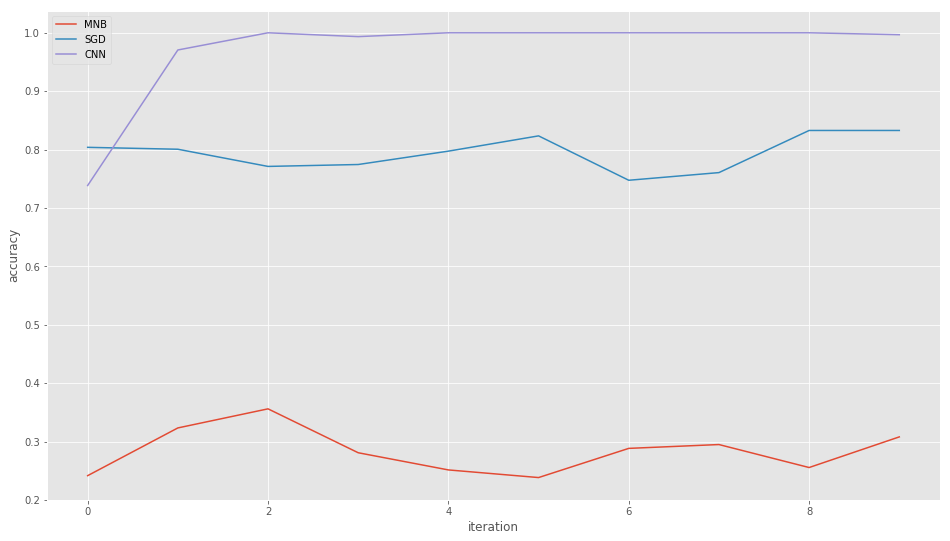

In [23]:
plt.figure(figsize=(16, 9))
plt.plot(range(len(mnb_cv_scores)), mnb_cv_scores)
plt.plot(range(len(sgd_cv_scores)), sgd_cv_scores)
plt.plot(range(len(cnn_cv_scores)), [item[1] for item in cnn_cv_scores])
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.legend(['MNB', 'SGD', 'CNN'])